# DSCI 100 Project

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction

### Background & Question

We wish to help Prof. Frank to figure out how to what types of players will be more likely to contribute more data for the Minecraft study.

There's a reddit rumor saying that truly dedicated people don't stop, never stop. They have obsessions. For example, mathematicans may spend years studying a single problem, while most people would not persist for years. Moderators on reddit may spends hours each day moderating posts on reddit, despite they are unpaid.

This leads me to think: are true gamers sleepless? If a gamer plays game at 4 AM, will the gamer be a real gamer that would provide endless data?

In this project, we will explore whether participants who play game overnight will have more `played_hours`.

## Dataset

We have two files `players.csv` and `sessions.csv`. Both contains a `hashedEmail`, which is the email of players obfuscated. `sessions.csv` also has start time and end time for each session, both in human readable format and UNIX epoch time format. `players.csv` contains 6 columns, `experience` which takes value such as `Beginner`, `Pro`, `Veteran` etc describing skill level of player, `subscribe` which is a boolean that describes whether the player is subscribed to newsletter. We also have `played_hours`, `name`, `gender` and `age`, which describes total recorded play time in hours, name of player, gender of player and age of player in years.

## Methods & Results

To answer the question, the very first step we need to do is to remove all records consisting of players who do not stay overnight. We say a player stays overnight to play game if the player plays game between 0 AM to 4 AM.

Let's start with loading the datasets.

In [7]:
players <- read_csv("data/players.csv") |> mutate(gender = as.factor(gender))
sessions <- read_csv("data/sessions.csv")
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ERROR: Error in players.head(4): could not find function "players.head"


Then, let's proceed to to parse the start time and the end time.

In [25]:
sessions_with_parsed_time <- sessions |> mutate(start_time = as_datetime(start_time, format = "%d/%m/%Y %H:%M"), 
                                                end_time = as_datetime(end_time, format = "%d/%m/%Y %H:%M"))
head(sessions_with_parsed_time)

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12


Then, we proceed to extract out the hours and minutes of start time and end time, and convert the hours to to minutes. I read https://ubc-dsci.github.io/dsci-100-student/REFERENCE_R.html over and over again and didn't see how to get hours and minutes out of a `dttm`. Therefore, we have to go out of the box and use `format`, which is not part of reference sheet.

In [26]:
sessions_with_time_in_hr <- sessions_with_parsed_time |> mutate(
    start_time_in_hr = as.numeric(format(start_time, "%H"))
    + as.numeric(format(start_time, "%M")) / 60,
    end_time_in_hr = as.numeric(format(end_time, "%H")) 
    + as.numeric(format(end_time, "%M")) / 60,
  )
head(sessions_with_time_in_hr)

hashedEmail,start_time,end_time,original_start_time,original_end_time,start_time_in_hr,end_time_in_hr
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12,18.200000,18.400000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12,23.550000,23.766667
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12,17.566667,17.950000
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12,3.366667,3.966667
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12,16.016667,16.200000
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12,15.133333,17.166667


Now, we have start time and end time in hour, it suffices for us to use filter. For a player to play overnight, there are following cases:
- Start time is between 0 AM to 4 AM
- Start time is greater than the end time (the player played pass midnight)

In [27]:
filtered_sessions <- sessions_with_time_in_hr |> filter(start_time_in_hr < 4 | start_time_in_hr > end_time_in_hr)
head(filtered_sessions)

hashedEmail,start_time,end_time,original_start_time,original_end_time,start_time_in_hr,end_time_in_hr
<chr>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12,3.366667,3.966667
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,2024-09-21 02:13:00,2024-09-21 02:30:00,1.72688e+12,1.72689e+12,2.216667,2.500000
96e190b0bf3923cd8d349eee467c09d1130af143335779251492eb4c2c058a5f,2024-06-21 02:31:00,2024-06-21 02:49:00,1.71894e+12,1.71894e+12,2.516667,2.816667
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-03 01:31:00,2024-07-03 01:35:00,1.71997e+12,1.71997e+12,1.516667,1.583333
f2826fb8dbce4d450348f99cb27ade184b713998d9679780442efaaf218038f2,2024-08-24 02:32:00,2024-08-24 03:12:00,1.72447e+12,1.72447e+12,2.533333,3.200000
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,2024-08-18 00:51:00,2024-08-18 03:15:00,1.72394e+12,1.72395e+12,0.850000,3.250000


Now, suffices to use semi_join to join `filtered_sessions` with `players`, to filter all players who play overnight.

In [28]:
filtered_players <- players |> semi_join(filtered_sessions, by = "hashedEmail")
head(filtered_players)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Veteran,TRUE,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,1.6,Lane,Female,23
Amateur,TRUE,a175d4741dc84e6baf77901f6e8e0a06f54809a34e6b5211159bced346f7fb3e,48.4,Xander,Female,17


Now, let us compute the average played hours across players who play overnight compared to the entire population, to see if the mean changes significantly.

In [24]:
mean_played_hour_overnight <- filtered_players |> summarize(mean = mean(played_hours))
mean_played_hour_overnight

mean_played_overall <- players |> summarize(mean = mean(played_hours))
mean_played_overall

mean
<dbl>
21.4


mean
<dbl>
5.845918


As we can see, there's a significant difference! The mean played hour across players who played overnight is a whopping 21.4, while the mean played hour across all players is only 5.84!

To analyze it further, let's draw two histograms, to analyze the played hour distribution across players who do play overnight and players overall.

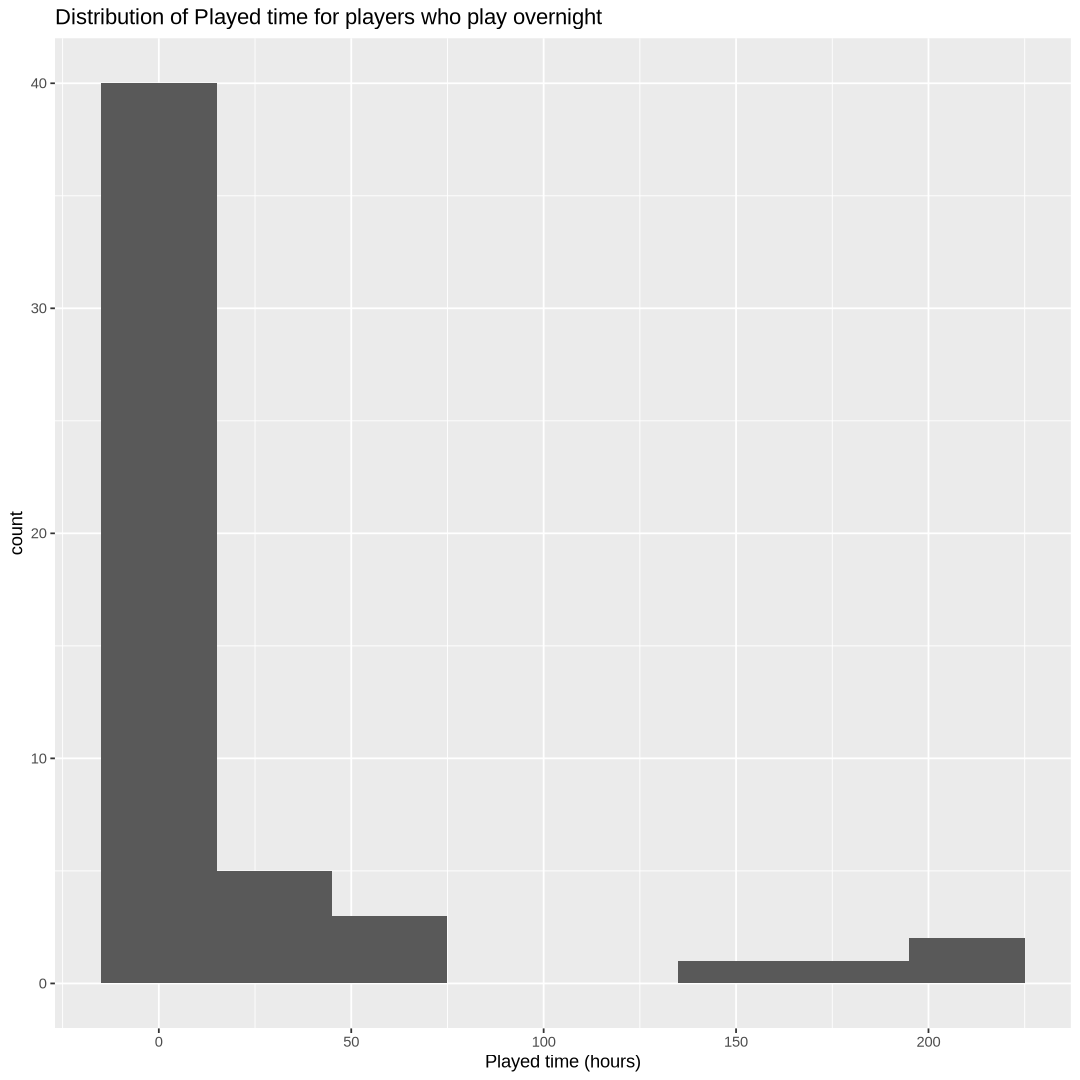

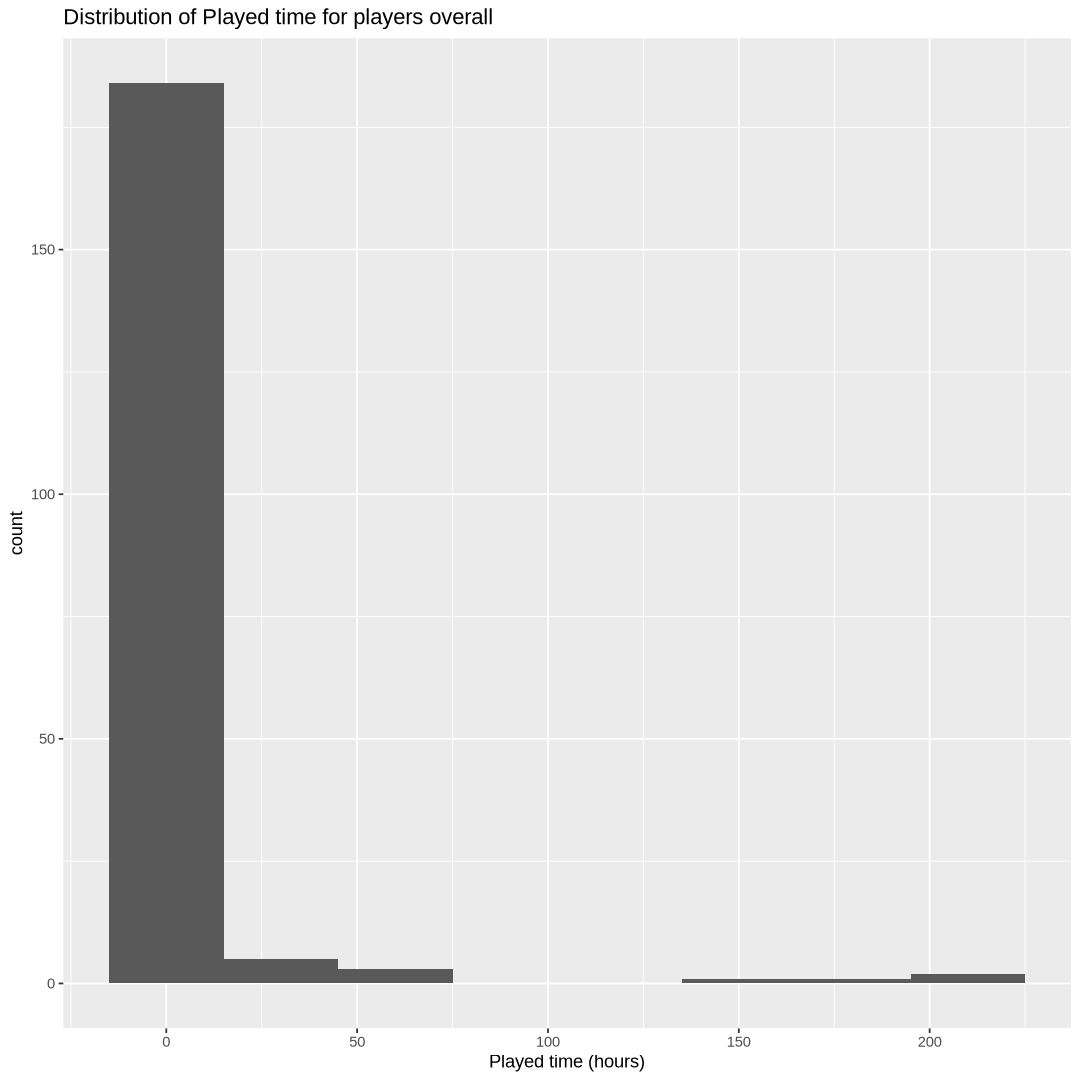

In [37]:
options(repr.plot.width = 9, repr.plot.height = 9)
histogram_night <- filtered_players |> ggplot(aes(x = played_hours)) + 
    geom_histogram(binwidth = 30) +
    xlab("Played time (hours)") +
    ggtitle("Distribution of Played time for players who play overnight")

histogram_overall <- players |> ggplot(aes(x = played_hours)) + 
    geom_histogram(binwidth = 30) +
    xlab("Played time (hours)") +
    ggtitle("Distribution of Played time for players overall")

histogram_night
histogram_overall

## Discussion

As we can see from the distributions, most players who play overnight actually also play a modest amount of time. 
In fact, both distributions look quite similar!
The difference, however, is that there's a higher propotion of players who play for 150 or even 200 hours across playes who play overnight.

Therefore, we cannot says that if a player plays overnight, then the player must be one of the dedicated player who play 150 hours. However, it is indeed significantly more likely for a player who plays overnight to have long play night.

This is not quite what I expected. I did expect the players who player overnight to have longer played times. But, I wasn't expecting a small portion of players playing more than 150 hours to skew the mean. I expected a more even distribution of play times.

One interesting question that there's a shortage of players who play around 100 hours. It leads me to think whether it is the case that if a player plays for 100 hours, the player will certainly play more?

In conclusion, Prof. Frank may want to pay special attention to players who plays overnight, as a small portion of them do tend to contribute significantly more data.